## SimpleNet
In this Project i created a simple Feed Forward Neural Network for classifiying cats and fishs!

In [54]:
#first let's import our libraries 
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In this section we will Set up The DataLoaders:

In [2]:
#This function will check if the path to the image is valid:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

# Here we will set up the transforms for every image:
* Resize image to 64x64
* Convert to tensor
* Normalize using ImageNet mean & std

In [3]:
img_transforms = transforms.Compose([
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )
])

In [4]:
train_path = './train/'
train_data = torchvision.datasets.ImageFolder(root=train_path, transform=img_transforms, is_valid_file=check_image)

In [6]:
val_path = './val/'
val_data = torchvision.datasets.ImageFolder(root=val_path, transform=img_transforms, is_valid_file=check_image)

In [7]:
test_path = './test/'
test_data = torchvision.datasets.ImageFolder(root=test_path, transform=img_transforms, is_valid_file=check_image)

In [11]:
#here we specify the size of our batch
batch_size = 64

In [12]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

## Now It's Time to define our Model Architecture:
we will call it SimpleNet it is simple combination of four Linear Layers and ReLU activation functions between them.


In [16]:
class SimpleNet(nn.Module):
    
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(64*64*3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 2)
    
    def forward(self, x):
        x = x.view(-1, 64*64*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [17]:
simplenet = SimpleNet()

## Create an Optimizer:
Here we will use the Adam optimizer with learning rate lr=0.001.

In [18]:
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)

# Working on CPU
As i do not have access to a gpu i will work on my locla cpu.

In [20]:
device = torch.device("cpu")

In [21]:
simplenet.to(device)

SimpleNet(
  (fc1): Linear(in_features=12288, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
)

## Training 
Calculating losses, optimizing our network and perform validation for each epoch.

In [38]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output, targets)
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)
        
        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [39]:
train(simplenet, optimizer, torch.nn.CrossEntropyLoss(), train_loader, val_loader, epochs=5, device=device)

/home/ahmed/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0, Training Loss: 0.48, Validation Loss: 0.52, accuracy = 0.77
Epoch: 1, Training Loss: 0.45, Validation Loss: 0.56, accuracy = 0.74
Epoch: 2, Training Loss: 0.43, Validation Loss: 0.53, accuracy = 0.79
Epoch: 3, Training Loss: 0.38, Validation Loss: 0.57, accuracy = 0.75
Epoch: 4, Training Loss: 0.34, Validation Loss: 0.61, accuracy = 0.72


# Making Predictions
Labels are in alphanumeric order, so `cat` will be 0, `fish` will be 1

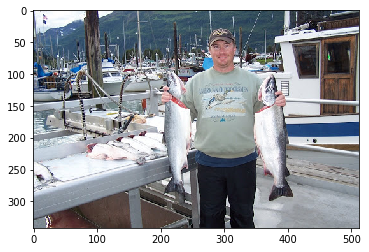

In [58]:
#show the images that we want to test :
#1 image of a fish
img = mpimg.imread("./val/fish/100_1422.JPG")
plt.imshow(img)

In [59]:
labels = ['cat','fish']
#enter an image of fish
img = Image.open("./val/fish/100_1422.JPG") 
img = img_transforms(img)#.to(device)



prediction = F.softmax(simplenet(img))
prediction = prediction.argmax()
print(labels[prediction]) 



fish


/home/ahmed/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


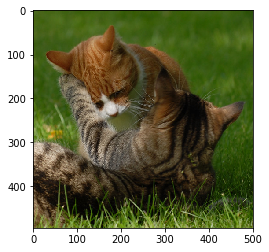

In [60]:
#let's plot an image of a cat
img = mpimg.imread("./val/cat/1041842900_1c5202b05c.jpg")
plt.imshow(img)

In [61]:
#2 now let's give it an image of a cat
#enter an image of cat:
img = Image.open("./val/cat/1041842900_1c5202b05c.jpg") 
img = img_transforms(img).to(device)



prediction = F.softmax(simplenet(img))
prediction = prediction.argmax()
print(labels[prediction]) 


cat


/home/ahmed/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


# Saving Models
We can either save the entire model using `save` or just the parameters using `state_dict`. Using the latter is normally preferable, as it allows you to reuse parameters even if the model's structure changes (or apply parameters from one model to another).

In [45]:
torch.save(simplenet, '/tmp/simplenet')
simplenet = torch.load('/tmp/simplenet')

/home/ahmed/anaconda3/envs/new_env/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SimpleNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [48]:
torch.save(simplenet.state_dict(), '/tmp/simplenet')
simplenet = SimpleNet()
simplenet_state_dict = torch.load('/tmp/simplenet')
simplenet.load_state_dict(simplenet_state_dict)

<All keys matched successfully>